In [32]:
# utils.py
import requests
import io
import numpy as np
import os

#Loads data from url
def make_request(url):
    print("Requesting data from {}...".format(url))
    response = requests.get('https://content.codecademy.com/courses/deeplearning-with-tensorflow/'+url)
    response.raise_for_status()
    response_data = io.BytesIO(response.content)
    return response_data
    
#Loads galaxy data
def load_galaxy_data():
  
  #If cached file not found, loads data from url
  if not os.path.isfile('./cached_data.npz'):
     response_data = make_request(url='galaxydata.npz')

     with open("cached_data.npz","wb") as save_file:
      save_file.write(response_data.read())
 
  #Load data using NumPy
  data = np.load('cached_data.npz')

  print("Successfully loaded galaxy data!")
  
  return data["data"],data["labels"]

In [33]:
# visualize.py
import tensorflow as tf
from matplotlib import pyplot as plt

#Visualizes convolutional layer activations
def visualize_activations(model, validation_iterator):

  #A keras model that will output our previous model's activations for each convolutional layer:
  activation_extractor = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers if "conv2d" in layer.name])

  #Take matplotlib frame and remove axes.
  def clean_plot(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

  #Dict mapping from class numbers to string labels:
  class_names = {0:"Regular",1:"Ringed",2:"Merger",3:"Other"}

  #Loads a sample batch of data
  sample_batch_input,sample_labels = validation_iterator.next()
 
  #Grabs the first five images
  sample_batch_input = sample_batch_input[:5]
  sample_labels = sample_labels[:5]

  #Makes predictions using model.predict(x)
  sample_predictions = model.predict(sample_batch_input)

  #Iterate of images, predictions, and true labels
  for i,(image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):

    image_name = "Galaxy_{}".format(i)

    #Gets predicted class with highest probability

    predicted_class = tf.argmax(prediction).numpy()

    #Gets correct label
    actual_class = tf.argmax(label).numpy()

    print(image_name)
    print("\tModel prediction: {}".format(prediction))
    print("\tTrue label: {} ({})".format(class_names[actual_class], actual_class))
    print("\tCorrect:", predicted_class == actual_class)

    #Saves image file using matplotlib
    sample_image = image
    clean_plot(plt.imshow(sample_image))

    plt.title(image_name+" Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[actual_class]))
    plt.show()
    model_layer_output = activation_extractor(tf.expand_dims(sample_image,0))
    
    plt.clf()

    #Iterates over each layer output
    for l_num,output_data in enumerate(model_layer_output):

      #Creates a subplot for each filter
      fig, axs = plt.subplots(1, output_data.shape[-1])
      
      #For each filter
      for i in range(output_data.shape[-1]):

        #Plots the filter's activations
        
        clean_plot(axs[i].imshow(output_data[0][:, :, i], cmap="gray"))
      plt.suptitle(image_name+" Conv {}".format(l_num),y=0.6)
      plt.show()
      plt.clf()

Successfully loaded galaxy data!
(1400, 128, 128, 3)
Epoch 1/8
224/224 [==============================] - 3s 14ms/step - loss: 1.2980 - categorical_accuracy: 0.3830 - auc_6: 0.6483 - val_loss: 1.1221 - val_categorical_accuracy: 0.4786 - val_auc_6: 0.7697
Epoch 2/8
224/224 [==============================] - 3s 13ms/step - loss: 1.1708 - categorical_accuracy: 0.4946 - auc_6: 0.7449 - val_loss: 1.1499 - val_categorical_accuracy: 0.4536 - val_auc_6: 0.7526
Epoch 3/8
224/224 [==============================] - 3s 13ms/step - loss: 1.1016 - categorical_accuracy: 0.5714 - auc_6: 0.7895 - val_loss: 1.2229 - val_categorical_accuracy: 0.4179 - val_auc_6: 0.7348
Epoch 4/8
224/224 [==============================] - 3s 13ms/step - loss: 1.0955 - categorical_accuracy: 0.5580 - auc_6: 0.7845 - val_loss: 1.0162 - val_categorical_accuracy: 0.6143 - val_auc_6: 0.8324
Epoch 5/8
224/224 [==============================] - 3s 13ms/step - loss: 1.0264 - categorical_accuracy: 0.6089 - auc_6: 0.8164 - val_loss:

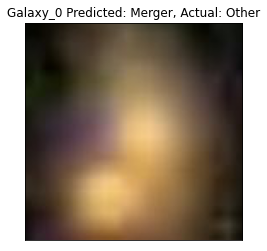

<Figure size 432x288 with 0 Axes>

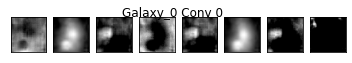

<Figure size 432x288 with 0 Axes>

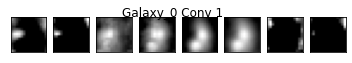

Galaxy_1
	Model prediction: [0.32737684 0.41328847 0.1065163  0.15281843]
	True label: Ringed (1)
	Correct: True


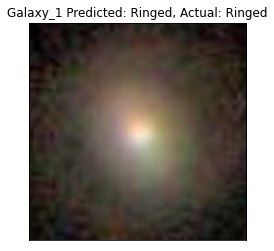

<Figure size 432x288 with 0 Axes>

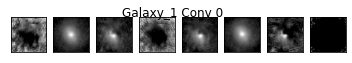

<Figure size 432x288 with 0 Axes>

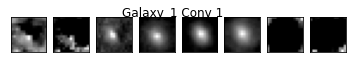

Galaxy_2
	Model prediction: [1.8071238e-02 1.3692578e-04 3.4267671e-02 9.4752419e-01]
	True label: Other (3)
	Correct: True


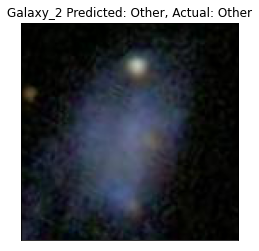

<Figure size 432x288 with 0 Axes>

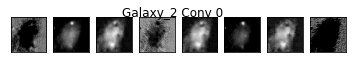

<Figure size 432x288 with 0 Axes>

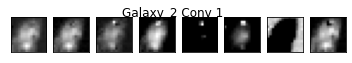

Galaxy_3
	Model prediction: [0.55833554 0.09084852 0.163886   0.1869299 ]
	True label: Regular (0)
	Correct: True


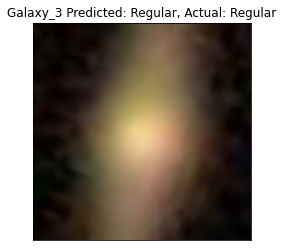

<Figure size 432x288 with 0 Axes>

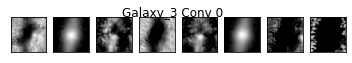

<Figure size 432x288 with 0 Axes>

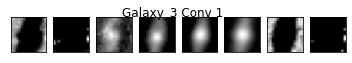

Galaxy_4
	Model prediction: [0.34018147 0.3715848  0.15190783 0.13632588]
	True label: Regular (0)
	Correct: False


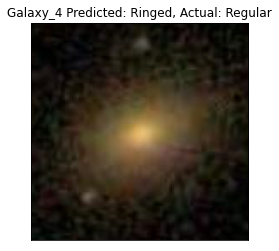

<Figure size 432x288 with 0 Axes>

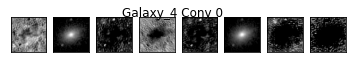

<Figure size 432x288 with 0 Axes>

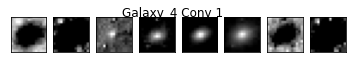

<Figure size 432x288 with 0 Axes>

In [34]:
# train.py
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

input_data, labels = load_galaxy_data()
# 1. print the dimensions of the input_data and labels:
print(input_data.shape)
#print(labels.shape)

# 2. divide the data into training and validation data:
# shuffle: bool, default=True
x_train, x_test, y_train, y_test = train_test_split(
    input_data, 
    labels, 
    test_size = 0.2,
    stratify = labels,
    random_state = 222
)

# Preprocess the input
# 3. Define an ImageDataGenerator, and configure it:
training_data_generator = ImageDataGenerator(
  rescale = 1 / 255,
)
# 4. create two NumpyArrayIterators:
training_iterator = training_data_generator.flow(
  x_train, 
  y_train,
  batch_size = 5
)
BATCH_SIZE = 5
validation_iterator = training_data_generator.flow(
  x_test, 
  y_test, 
  batch_size = BATCH_SIZE
)

# 5. build your model, starting with the input shape and output layer:
model = tf.keras.Sequential()

# set the input layer:
model.add(tf.keras.Input(
  shape = input_data.shape[1:]
))

# Configuring Convolutional Layer 
# 7. filters:
# 7.1
model.add(tf.keras.layers.Conv2D(
  8, 
  3, 
  strides = 2,
  activation = "relu"
)) 
# 7.2
model.add(tf.keras.layers.MaxPooling2D(
  pool_size = (2, 2),
  strides = (2, 2)
))
# 7.3
model.add(tf.keras.layers.Conv2D(
  8, 
  3, 
  strides = 2,
  activation = "relu"
)) 
# 7.4
model.add(tf.keras.layers.MaxPooling2D(
  pool_size = (2, 2),
  strides = (2, 2)
))
# 7.5 Flatten Layer
model.add(tf.keras.layers.Flatten())
# 7.6 set the hidden layer
Dense = tf.keras.layers.Dense
model.add(Dense(
  16, 
  activation = "relu" 
))
# 7.7 set the output layer:
model.add(Dense(
  4, 
  activation = "softmax"
))

# 8: At this point, your model should have 7,164 parameters. 
#model.summary()

# 6. compile your model:
model.compile(
  loss = tf.keras.losses.CategoricalCrossentropy(), 
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
  metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()]
)

# Train and evaluate the classification model
# 9. train your model:
model.fit(
  training_iterator, 
  steps_per_epoch = len(training_iterator.x) / BATCH_SIZE,
  epochs = 8,
  validation_data = validation_iterator,
  validation_steps = len(validation_iterator.x) / BATCH_SIZE
)

# 12. visualize how your convolutional neural network processes images
visualize_activations(model,validation_iterator)
